In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
 
from tensorflow.keras import layers, initializers 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers

from keras import optimizers

import re

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('spanish'))

%matplotlib inline 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show() 

In [5]:
filename = "/Users/derickmorales/Desktop/TFM Derick Morales Aviles/NPS.csv"

df = pd.read_csv(filename
                 , encoding = 'utf-8'
                 , delimiter = ','
                 , header = 0             
                 , index_col = False
                 , usecols = [0, 1, 2, 3, 4, 5, 6]
                 , names = ['Comentarios', 'Experiencia en Cajas', 'Amabilidad del Personal', 'Calidad', 'Surtido', 'Precios', 'NPS']
)

target = "NPS"
print(df.shape)
df.head() 

(30269, 7)


,Comentarios,Experiencia en Cajas,Amabilidad del Personal,Calidad,Surtido,Precios,NPS
0,Mejorar el respeto de sus empleados hacia noso...,3,3,3,3,3,4
1,"Excelente el servicio por parte del personal, ...",5,5,4,4,3,8
2,en la mayoria de ocaciones el precio no coinci...,4,4,5,5,5,9
3,Cuando hacen ofertas se presentan muchos produ...,4,5,5,5,4,7
4,Ay uno productos que son mas caros que un supe...,5,5,4,5,3,10


In [6]:
#palabras totales en el dataframe en las 30,269 filas de comentarios
df.Comentarios.str.split().str.len().sum()

623573

In [7]:
#Limpieza texto

pat1 = r'[0-9]'  #numeros
pat2 = '[^a-zA-Z]+' 
pat = r'|'.join((pat1, pat2))

def get_clean_text(Comentarios):
    Comentarios = Comentarios.lower() # lowercase
    Comentarios = re.sub(pat, ' ', Comentarios) 
    Comentarios = [w for w in tok.tokenize(Comentarios) if not w in stop_words] # remove stop_words
    Comentarios = [w for w in Comentarios if len(w)>1] 
    Comentarios = (' '.join(Comentarios)).strip() 
    return Comentarios

df['Comentarios_limpios'] = [get_clean_text(t) for t in df['Comentarios']]
df.head()

,Comentarios,Experiencia en Cajas,Amabilidad del Personal,Calidad,Surtido,Precios,NPS,Comentarios_limpios
0,Mejorar el respeto de sus empleados hacia noso...,3,3,3,3,3,4,mejorar respeto empleados hacia clientes espec...
1,"Excelente el servicio por parte del personal, ...",5,5,4,4,3,8,excelente servicio parte personal compre art c...
2,en la mayoria de ocaciones el precio no coinci...,4,4,5,5,5,9,mayoria ocaciones precio coincide producto
3,Cuando hacen ofertas se presentan muchos produ...,4,5,5,5,4,7,hacen ofertas presentan productos pasar caja a...
4,Ay uno productos que son mas caros que un supe...,5,5,4,5,3,10,ay productos mas caros super mas peque tienda


In [8]:
# 316,229 palabras totales en el dataframe luego de remover stopwords  
df.Comentarios_limpios.str.split().str.len().sum() 

316229

In [9]:
#media de columna NPS 
df['NPS'].mean()  

8.073540586078165

In [10]:
df['avg']=df['NPS'].mean() 

In [11]:
#MSE
mean_squared_error(df['NPS'].values, df['avg']) 

6.496028896078165

In [12]:
#RMSE
mean_squared_error(df['NPS'].values, df['avg'], squared=False) 

2.5487308402571984

In [13]:
#MAE 
mean_absolute_error(df['NPS'].values, df['avg']) 

1.9009496838691964

In [14]:
#dataframe, Nps = target, Comentarios_limpios = predictor
df = df.iloc[:, [6,7]]

NPS = df.iloc[:,0]
Comentarios_limpios = df.iloc[:,1]

df.head()

,NPS,Comentarios_limpios
0,4,mejorar respeto empleados hacia clientes espec...
1,8,excelente servicio parte personal compre art c...
2,9,mayoria ocaciones precio coincide producto
3,7,hacen ofertas presentan productos pasar caja a...
4,10,ay productos mas caros super mas peque tienda


In [15]:
#Frecencia termino

In [16]:
from collections import Counter

def get_freq_str(df, sep = ',', threshold = 0, top_n = 0):
    df = df.copy(deep=True)
    df = df[df.notnull()]
    
    df = df.apply(lambda x: Counter(x.split(sep)))
    c = Counter()
    for d in df:
        c.update(d)
    
    df = pd.DataFrame(list(c.items()), columns=[df.name, 'freq'])
    
    if threshold != 0:
        df = df[df['freq']>threshold]
        
    df = df.sort_values(by='freq', ascending=False)
    
    if top_n != 0:
        df = df.head(top_n)
       
    return df

In [17]:
freq = get_freq_str(df['Comentarios_limpios'], sep = ' ', threshold = 0, top_n = 0)
freq

,Comentarios_limpios,freq
31,productos,6463
93,precios,3885
11,servicio,2999
131,gracias,2931
6,jumbo,2848
...,...,...
14023,encantas,1
14024,cosevha,1
14025,desastrozos,1
14026,perfecci,1


In [18]:
#tabla frecuencia de la palabra 11,594 aparecen 1 sola vez
one_position = freq.tail(11594)
one_position.head()

,Comentarios_limpios,freq
17862,telefoni,1
17933,ladrarle,1
17861,incorforme,1
17935,expidan,1
17850,puntas,1


In [19]:
type(one_position), type(Comentarios_limpios)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [20]:
len(one_position), len(freq) 

(11594, 22137)

In [21]:
# filtro = palabras con frecuencia de mas de 5
filtros = freq[freq['freq'] > 5]['Comentarios_limpios'].unique()
filtros 

array(['productos', 'precios', 'servicio', ..., 'atalayas', 'juegan',
       'exelencia'], dtype=object)

In [22]:
for filtro in filtros:
   
    filtro_new_name = filtro 
    try:
        df[filtro_new_name] = df['Comentarios_limpios'].str.lower().str.contains(filtro).astype('int')
    except: 
        print(filtro)  

In [23]:
print(df.shape)
df 

(30269, 4743)


,NPS,Comentarios_limpios,productos,precios,servicio,gracias,jumbo,promociones,mas,tienda,...,pantalla,caballero,tradicional,tono,despectivo,almorzando,accequibles,atalayas,juegan,exelencia
0,4,mejorar respeto empleados hacia clientes espec...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,excelente servicio parte personal compre art c...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,mayoria ocaciones precio coincide producto,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,hacen ofertas presentan productos pasar caja a...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,ay productos mas caros super mas peque tienda,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30264,10,deber an tener surtido computaci gracias,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30265,5,varios productos precio coive realizar compras,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30266,10,atencion general excelente,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30267,10,destaca orden atenci cliente,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split Data

In [24]:
#Experimentation parameters

vocab_size = 30269 #cantidad maxima de tokens a ser considerados en el vocabulario 


max_length = 25 #cantidad que entrara como input a la red, todos deben ser iguales por eso usamos un maximo 
                #la red neur. necesita que siempre entre el mismo valor (input)

    
trunc_type = 'post' #en caso de exceder el max_length, truncar (cortar) al final, no mas de 40 en este caso
    
padding_type = 'post' # de ser necesario rellenar con ceros porque no llega al max_length, hacerlo al final,
                      # del documento
    
oov_tok = '<OOV>' #si no encuentra alguna palabra en el embedding le asigna "OOV"

In [25]:
# parametrization
test_size = 0.1
val_size = 0.3

df = df.sample(frac=1)
train_df, test_df = train_test_split(df
                                     , test_size = test_size)
train_df, val_df = train_test_split(train_df
                                    , test_size = val_size)

# Form np arrays 
train_features = np.array(train_df[train_df.columns.difference([target])])
val_features = np.array(val_df[val_df.columns.difference([target])])
test_features = np.array(test_df[test_df.columns.difference([target])])

train_labels = np.array(train_df[[target]])
val_labels = np.array(val_df[[target]])
test_labels = np.array(test_df[[target]])

input_len = train_features.shape[1]

In [26]:
train_df.shape, val_df.shape ,test_df.shape

((19069, 4743), (8173, 4743), (3027, 4743))

In [27]:
x_train = train_df.iloc[:, 1] 
y_train = train_df.iloc[:, 0] 

x_val = val_df.iloc[:, 1] 
y_val = val_df.iloc[:, 0] 

x_test = test_df.iloc[:, 1] 
y_test = test_df.iloc[:, 0] 

In [28]:
y_test 

7275     10
10061     8
24488     9
6417     10
10921     8
         ..
21033     7
2974      3
14096     0
24573    10
5990      9
Name: NPS, Length: 3027, dtype: int64

In [29]:
label_tokenizer = Tokenizer() 

tokenizer = Tokenizer(num_words = vocab_size 
                      , oov_token=oov_tok) 

tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_val) 
tokenizer.fit_on_texts(x_test) 

word_index = tokenizer.word_index 

print('Esto es un ejemplo de 10 tokens en el word_index :' + str(dict(list(word_index.items())[0:10])))

Esto es un ejemplo de 10 tokens en el word_index :{'<OOV>': 1, 'productos': 2, 'precios': 3, 'servicio': 4, 'gracias': 5, 'jumbo': 6, 'promociones': 7, 'mas': 8, 'tienda': 9, 'cajas': 10}


In [30]:
#una vez tokenizado, transformar nuestra data actual
x_train_seq = tokenizer.texts_to_sequences(x_train)

x_val_seq = tokenizer.texts_to_sequences(x_val) 

x_test_seq = tokenizer.texts_to_sequences(x_test)

In [31]:
#realizacion de padding
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

x_val_pad = pad_sequences(x_val_seq , maxlen=max_length, padding=padding_type, truncating=trunc_type)

x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type) 

In [32]:
x_train_pad

array([[ 2082,   333,    23, ...,     5,     0,     0],
       [  540,    35,   787, ...,     0,     0,     0],
       [ 1172, 10545,   106, ...,     0,     0,     0],
       ...,
       [   33,    15,   868, ...,     0,     0,     0],
       [  731,     2,   511, ...,     0,     0,     0],
       [   35,    93,   116, ...,     0,     0,     0]], dtype=int32)

In [42]:
#ejemplo de transformación
print('original text :' + str(x_train[10000]))
print('______________________________________________________________')
print('tokenized text :' + str(x_train_seq[10000]))
print('______________________________________________________________')
print('padded text :' + str(x_train_pad[10000]))
print('______________________________________________________________')
print('original label :' + str(y_train[10000])) 

original text :hice comparaci precio realmente est costosos definitivamente vuelvo mercar all
______________________________________________________________
tokenized text :[2236, 1228, 185, 1605, 1228, 64, 90, 221, 351, 267, 5133, 290, 1819, 181, 2898, 527, 33, 596, 2462, 1612, 3535, 112]
______________________________________________________________
padded text :[2236 1228  185 1605 1228   64   90  221  351  267 5133  290 1819  181
 2898  527   33  596 2462 1612 3535  112    0    0    0]
______________________________________________________________
original label :7


In [43]:
# los 0 = padding aplicado
x_train_pad[10000] 

array([2236, 1228,  185, 1605, 1228,   64,   90,  221,  351,  267, 5133,
        290, 1819,  181, 2898,  527,   33,  596, 2462, 1612, 3535,  112,
          0,    0,    0], dtype=int32)

### Machine Learning:

#### 1.Regresión Lineal

In [50]:
#definiendo modelo
modeloReg = LinearRegression()

#entrenamiento modelo RL 
modeloReg.fit(x_train_pad,y_train) 

LinearRegression()

In [252]:
#prediciones 
Y_pred = modeloReg.predict(x_test_pad)
Y_pred 

array([8.1918133 , 7.29029129, 7.10454311, ..., 7.53287072, 8.33928579,
       8.18040544])

In [249]:
predicciones_Reg = modeloReg.predict(X = x_test_pad)
print(predicciones_Reg[0:10,])

mae =  mean_absolute_error(
        y_true  = y_test,
        Y_pred  = predicciones_Reg,
       )
print("")
print(f"El error (mae) de test es: {mae}")

[8.1918133  7.29029129 7.10454311 8.32373272 8.28376837 8.29272174
 8.35499623 8.3614656  7.38652015 8.20317989]

El error (mae) de test es: 1.8662733731095953


In [250]:
predicciones_Reg = modeloReg.predict(X = x_test_pad)
print(predicciones_Reg[0:10,])

rmse = mean_squared_error(
        y_true  = y_test,
        Y_pred  = predicciones_Reg,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse}")

[8.1918133  7.29029129 7.10454311 8.32373272 8.28376837 8.29272174
 8.35499623 8.3614656  7.38652015 8.20317989]

El error (rmse) de test es: 2.4689340058932543


In [255]:
#metricas de error
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, Y_pred))
print('Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, Y_pred))) 

Mean Absolute Error: 1.8662733731095953
Mean Squared Error: 2.4689340058932543


In [254]:
#valores reales vs prediciones modelo vs
tabla = pd.DataFrame({'Actual': y_test, 'Predicted': Y_pred})
tabla.head(30) 

,Actual,Predicted
4844,10,8.191813
16887,10,7.290291
4806,7,7.104543
16172,10,8.323733
9573,10,8.283768
8268,0,8.292722
13272,10,8.354996
12342,6,8.361466
10266,7,7.386520
7777,3,8.203180


#### 2. Random Forest Regressor 

In [29]:
random_f = RandomForestRegressor(criterion='mae', n_jobs=-1) 

In [30]:
random_f.fit(x_train_pad, y_train, sample_weight=None)

RandomForestRegressor(criterion='mae', n_jobs=-1)

In [79]:
predicciones2 = random_f.predict(X = x_test_pad)

mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = predicciones2,
       )
print(f"El error (mae) de test es: {mae}")

El error (mae) de test es: 1.8179625041295011


In [35]:
predicciones1 = random_f.predict(X = x_test_pad)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones1,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 2.45239149527257


#### 3. Gradient Boosting Regressor

In [44]:
GradientB_model = GradientBoostingRegressor(loss='lad', learning_rate=0.1)  

In [45]:
GradientB_model.fit(x_train_pad, y_train) 

GradientBoostingRegressor(loss='lad')

In [47]:
GradB_preds = GradientB_model.predict(x_test_pad)
GradB_preds

array([9.75638267, 8.69587825, 8.94810608, ..., 7.28894266, 8.87914753,
       8.90523321])

In [48]:
mae = mean_absolute_error(
        y_true  = y_test,
        y_pred  = GradB_preds)
print(f"El error (mae) de test es: {mae}")

El error (mae) de test es: 1.6279976587196578


In [49]:
rmse =mean_squared_error(
        y_true  = y_test,
        y_pred  = GradB_preds,
        squared = False
)
print(f"El error (rmse) de test es: {rmse}") 

El error (rmse) de test es: 2.499888523553399


In [50]:
mse =mean_squared_error(
        y_true  = y_test,
        y_pred  = GradB_preds)
print(f"El error (rmse) de test es: {mse}") 

El error (rmse) de test es: 6.249442630193993


In [51]:
#metricas de error en Gradient Boosting Regressor
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, GradB_preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, GradB_preds)))

Mean Absolute Error: 1.6279976587196578
Root Mean Squared Error: 2.499888523553399


In [86]:
tabla_GB = pd.DataFrame({'Valor Correcto':y_test, 'Valor predecido':GradB_preds}) 
tabla_GB.head()

,Valor Correcto,Valor predecido
3209,8,8.429699
6083,10,7.426227
25495,8,7.958826
17811,10,8.887851
14490,9,8.110807


In [54]:
x_test

7275                                   decirles gracias ok
10061               gustar precios poca oandemia suban mas
24488    carnes frutas verduras deber an tener precios ...
6417     muchas ocasiones salen productos da ados fruta...
10921                  claridad precios aplican descuentos
                               ...                        
21033    atenci cliente sima siempre mayor empleados es...
2974     iendo fila dijeron podr pagar caja alimentos p...
14096    hace varios dej compras xito flora convert cli...
24573    as electrodom sticos suben precios altos hace ...
5990     extra ausencia marca propia ayuda ostensibleme...
Name: Comentarios_limpios, Length: 3027, dtype: object

In [63]:
tabla_GB = pd.DataFrame({'Comentario Aleatorio':x_test,'Valor Correcto':y_test, 'Valor predicho':GradB_preds}) 
tabla_GB.head()

,Comentario Aleatorio,Valor Correcto,Valor predicho
7275,decirles gracias ok,10,9.756383
10061,gustar precios poca oandemia suban mas,8,8.695878
24488,carnes frutas verduras deber an tener precios ...,9,8.948106
6417,muchas ocasiones salen productos da ados fruta...,10,8.697980
10921,claridad precios aplican descuentos,8,9.293938


### Embedding 

In [64]:
import os

In [65]:
# embedding castellano
embedding_dim = 300

path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/Users/derickmorales/Downloads/SBW-vectors-300-min5.txt")

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1000654 word vectors.


In [66]:
hits = 0
misses = 0

embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():   
    embedding_vector = embeddings_index.get(word)  
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))  


Converted 16911 words (5226 misses)


In [ ]:
#sumatoria de vectores del embedding para cada comentario
# devolviendo un solo vector representativo del comentario 

data_vectors = []
for item_sentence in df.Comentarios_limpios.to_numpy():
    items_words = item_sentence.split(sep=' ') 
    vector_temp = np.zeros((1,300), dtype=float)
    for item in items_words:
        vector_temp = vector_temp + embeddings_index[item]
        vector_temp = vector_temp / 25
    data_vectors.append(vector_temp[0])

df1 = pd.DataFrame(data=data_vectors)
df1['NPS'] = df.NPS.to_numpy()
df1.head()

In [67]:
#word_index = num. palabras que vectoriza el embedding
len(word_index),    len(embedding_matrix)

(22137, 22138)

In [68]:
type(word_index) #diccionario que le asigna un token a cada palabra distinta

dict

In [46]:
type(embeddings_index) #dicionario del embedding utilizado, que le asigna los 300 vectores ala palabra 

dict

In [69]:
len(word_index), len(embeddings_index) 

(22137, 1000654)

In [116]:
type(embeddings_index), type(Comentarios_limpios)

(dict, pandas.core.series.Series)

In [117]:
len(embeddings_index), len(Comentarios_limpios)

(1000654, 30269)

In [115]:
type(embeddings_index), type(embedding_matrix), type(Comentarios_limpios)

(dict, numpy.ndarray, pandas.core.series.Series)

In [27]:
embeddings_index['producto']   #ejemplo vectorizacion palabra 300d. 

array([ 0.048358, -0.00164 , -0.026568,  0.064346,  0.027049,  0.026857,
       -0.02286 ,  0.03639 ,  0.035767, -0.028711, -0.057302,  0.027581,
        0.078093, -0.149802,  0.154569,  0.04085 , -0.033624, -0.070823,
        0.003926, -0.034632, -0.009493, -0.089502, -0.081311,  0.097032,
        0.086833, -0.023152, -0.076544,  0.067751,  0.060671,  0.0791  ,
        0.02669 , -0.078213,  0.02788 , -0.001158, -0.018961,  0.030346,
       -0.027766, -0.013391,  0.028716, -0.054395,  0.050055, -0.048826,
       -0.013409, -0.079461, -0.030608, -0.075821, -0.010481,  0.03208 ,
       -0.016938,  0.126305,  0.028474,  0.057286, -0.010987,  0.103091,
       -0.078813,  0.075172, -0.011602, -0.012449,  0.094767,  0.020715,
       -0.031707,  0.02611 , -0.039625, -0.051285, -0.021913,  0.005294,
       -0.10579 ,  0.092779, -0.100367,  0.032994, -0.012741, -0.038141,
       -0.088311,  0.145536, -0.075451,  0.067653, -0.077851,  0.003428,
        0.059094, -0.065998, -0.013117, -0.076995, 

In [28]:
#ejemplo sumando 3 palabras de un comentario para tener un vector representativo de las 3 
(embeddings_index['mejorar']+embeddings_index['tema']+embeddings_index['cajas'])/3

array([-7.27946684e-02,  4.07099957e-03,  3.17433327e-02, -4.82533360e-03,
       -4.19120006e-02,  5.53653352e-02,  1.35596665e-02, -2.48729978e-02,
       -6.98335469e-04, -3.00316662e-02, -1.91120002e-02, -5.58256656e-02,
       -2.14896705e-02, -4.92889993e-02,  8.03846642e-02,  5.30873351e-02,
        1.43613322e-02,  8.19966570e-03,  2.24843323e-02, -2.25586668e-02,
       -1.70990005e-02, -7.92913362e-02,  4.15923335e-02,  4.80646677e-02,
        1.36563331e-02, -8.41876641e-02, -4.02796678e-02,  6.43553287e-02,
       -3.53596695e-02,  1.45236671e-01,  2.26196647e-02, -3.16476636e-02,
       -4.91133565e-03, -2.84946654e-02,  3.21773328e-02,  9.34666768e-03,
       -1.02633366e-03, -2.83590015e-02, -1.51530011e-02, -2.44126674e-02,
        2.28396654e-02,  3.79186682e-02, -3.26060019e-02, -2.27420013e-02,
        4.18643355e-02, -5.32613285e-02,  5.84309995e-02,  2.57936660e-02,
        5.64699993e-03,  2.41873339e-02,  1.50643326e-02,  4.21366654e-02,
       -1.24039995e-02, -

In [70]:
len(Comentarios_limpios), len(embeddings_index), len(embedding_matrix), len(word_index)

(30269, 1000654, 22138, 22137)

In [52]:
#ejemplo comentario, podemos notar errores ortograficos 
df.Comentarios_limpios.iloc[1]

'permitir mezclar productos aseo ndolas comida'

In [71]:
#input, array 
# 22138 son las palabras distintas que el embedding intenta buscar
type(embedding_matrix), len(embedding_matrix)

(numpy.ndarray, 22138)

In [72]:
vocab_size = 22138 

# Modelos

### Red Neuronal

In [73]:
from tensorflow.keras import optimizers  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.layers import Embedding

In [74]:
from keras import models 
from keras import layers

In [75]:
len_word_index = len(word_index)
len_word_index 

22137

In [81]:
x_train_pad.shape, x_val_pad.shape ,x_test_pad.shape 

((19069, 25), (8173, 25), (3027, 25))

In [114]:
#modelo 1 api Sequential

model = models.Sequential()
model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))



model.add(layers.Flatten())                               
model.add(layers.Dense(256, activation='relu'))  
model.add(layers.Dense(256, activation='relu'))    
model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(learning_rate=1e-2)  #quite un cero

model.compile(loss='mean_absolute_error', #'mae'
            optimizer=optimizer,
            metrics=['mse','mae'])  

model.summary()  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 25, 300)           6641400   
_________________________________________________________________
flatten_6 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               1920256   
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 257       
Total params: 8,627,705
Trainable params: 1,986,305
Non-trainable params: 6,641,400
_________________________________________________________________


In [115]:
#early stop

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #val_mae
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [116]:
history = model.fit(x_train_pad,y_train,
                   epochs=50, 
                   batch_size=64, 
                   callbacks=[callback],
                   validation_data=(x_val_pad, y_val))  

len(history.history['loss'])

Epoch 1/50
298/298 [==============================] - 5s 17ms/step - loss: 9.6911 - mse: 2730.2511 - mae: 9.6911 - val_loss: 1.6823 - val_mse: 6.3576 - val_mae: 1.6823
Epoch 2/50
298/298 [==============================] - 5s 16ms/step - loss: 1.7977 - mse: 7.0527 - mae: 1.7977 - val_loss: 1.7049 - val_mse: 5.9260 - val_mae: 1.7049
Epoch 3/50
298/298 [==============================] - 5s 17ms/step - loss: 1.6686 - mse: 6.3241 - mae: 1.6686 - val_loss: 1.6406 - val_mse: 6.4715 - val_mae: 1.6406
Epoch 4/50
298/298 [==============================] - 5s 17ms/step - loss: 1.6353 - mse: 6.2903 - mae: 1.6353 - val_loss: 1.6324 - val_mse: 6.5420 - val_mae: 1.6324
Epoch 5/50
298/298 [==============================] - 5s 17ms/step - loss: 1.6083 - mse: 6.0666 - mae: 1.6083 - val_loss: 1.6628 - val_mse: 6.1488 - val_mae: 1.6628
Epoch 6/50
298/298 [==============================] - 5s 18ms/step - loss: 1.5846 - mse: 5.7986 - mae: 1.5846 - val_loss: 1.7017 - val_mse: 7.0504 - val_mae: 1.7017
Epoch 7

34

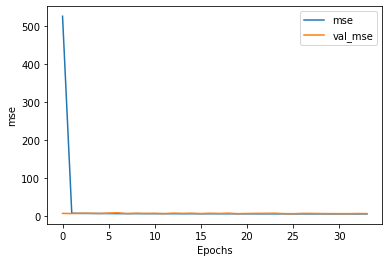

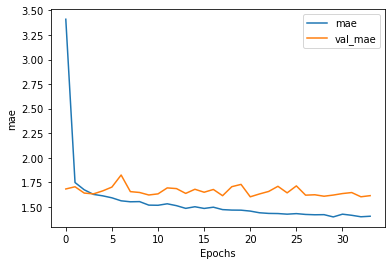

In [117]:
#graficos comparacion metricas de error en entrenamiento vs validacion
plot_graphs(history, "mse") 
plot_graphs(history, "mae") 

In [64]:
predictions_x = model.predict(x_test_pad)
predictions_x

array([[8.898596 ],
       [8.282033 ],
       [8.101082 ],
       ...,
       [7.2646456],
       [8.950983 ],
       [8.503765 ]], dtype=float32)

In [65]:
evaluate_train = model.evaluate(x_train_pad, y_train)

596/596 [==============================] - 3s 5ms/step - loss: 1.3759 - mse: 4.9171 - mae: 1.3759


In [66]:
evaluate_validation = model.evaluate(x_val_pad, y_val)

256/256 [==============================] - 1s 5ms/step - loss: 1.6825 - mse: 6.5040 - mae: 1.6825


In [67]:
evaluate_test = model.evaluate(x_test_pad, y_test)

95/95 [==============================] - 1s 5ms/step - loss: 1.6169 - mse: 5.9218 - mae: 1.6169


In [90]:
#model1_Seq = pd.DataFrame({'Validation':evaluate_validation, 'Test':evaluate_test}) 
#model1_Seq

In [68]:
#Modelo 2 api Functional

In [70]:
input_layer = layers.Input(shape=(25,))  

embedding = layers.Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False) (input_layer)

In [71]:
_, uno, dos = embedding.shape

In [72]:
uno, dos

(25, 300)

In [92]:
#Modelo 2 API Funcional

input_layer = layers.Input(shape=(25,))         
embedding = layers.Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False)(input_layer)

_, dim_rows, dim_columns = embedding.shape


word_list = tf.unstack(embedding, axis=1)
merging = layers.Average()(word_list)


dense1 = layers.Dense(512, activation="relu")(merging)
dense2 = layers.Dense(256, activation="relu")(dense1)
output = layers.Dense(1)(dense2)

model = tf.keras.models.Model(inputs=[input_layer], outputs=[output])
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='mean_absolute_error',  
            optimizer=optimizer,
            metrics=['mse','mae'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 25, 300)      6641400     input_4[0][0]                    
__________________________________________________________________________________________________
tf.unstack_3 (TFOpLambda)       [(None, 300), (None, 0           embedding_5[0][0]                
__________________________________________________________________________________________________
average_3 (Average)             (None, 300)          0           tf.unstack_3[0][0]               
                                                                 tf.unstack_3[0][1]         

In [93]:
history = model.fit(x_train_pad,y_train,
                   epochs=50, 
                   batch_size=64,              
                   validation_data=(x_val_pad, y_val))  

Epoch 1/50
298/298 [==============================] - 4s 11ms/step - loss: 2.3821 - mse: 11.2159 - mae: 2.3821 - val_loss: 1.7277 - val_mse: 6.1775 - val_mae: 1.7277
Epoch 2/50
298/298 [==============================] - 3s 9ms/step - loss: 1.7391 - mse: 6.7268 - mae: 1.7391 - val_loss: 1.7499 - val_mse: 6.0626 - val_mae: 1.7499
Epoch 3/50
298/298 [==============================] - 3s 9ms/step - loss: 1.6931 - mse: 6.5800 - mae: 1.6931 - val_loss: 1.7619 - val_mse: 5.9738 - val_mae: 1.7619
Epoch 4/50
298/298 [==============================] - 3s 10ms/step - loss: 1.7335 - mse: 6.7146 - mae: 1.7335 - val_loss: 1.7454 - val_mse: 7.5780 - val_mae: 1.7454
Epoch 5/50
298/298 [==============================] - 3s 9ms/step - loss: 1.7038 - mse: 6.7549 - mae: 1.7038 - val_loss: 1.6898 - val_mse: 6.0637 - val_mae: 1.6898
Epoch 6/50
298/298 [==============================] - 3s 10ms/step - loss: 1.6852 - mse: 6.5312 - mae: 1.6852 - val_loss: 1.6556 - val_mse: 6.6945 - val_mae: 1.6556
Epoch 7/50
2

In [75]:
evaluate_train = model.evaluate(x_train_pad, y_train)

596/596 [==============================] - 3s 4ms/step - loss: 1.6674 - mse: 6.6101 - mae: 1.6674


In [76]:
evaluate_validation = model.evaluate(x_val_pad, y_val)

256/256 [==============================] - 1s 5ms/step - loss: 1.6735 - mse: 6.7569 - mae: 1.6735


In [77]:
evaluate_test = model.evaluate(x_test_pad, y_test)

95/95 [==============================] - 0s 5ms/step - loss: 1.6119 - mse: 6.1406 - mae: 1.6119


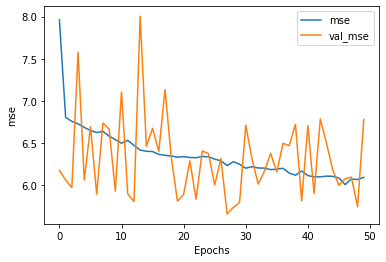

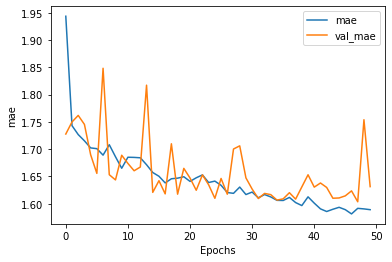

In [94]:
plot_graphs(history, "mse") 
plot_graphs(history, "mae") 

In [97]:
#early stop

tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [98]:
#Modelo 2 API Funcional

input_layer = layers.Input(shape=(25,))         
embedding = layers.Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False)(input_layer)

_, dim_rows, dim_columns = embedding.shape


word_list = tf.unstack(embedding, axis=1)
merging = layers.Average()(word_list)


dense1 = layers.Dense(512, activation="relu")(merging)
dense2 = layers.Dense(256, activation="relu")(dense1)
output = layers.Dense(1)(dense2)

model = tf.keras.models.Model(inputs=[input_layer], outputs=[output])
optimizer = keras.optimizers.Adam(lr=0.001) 
model.compile(loss='mean_absolute_error',  
            optimizer=optimizer,
            metrics=['mse','mae'])

#model.summary()

In [99]:
history = model.fit(x_train_pad,y_train,
                   epochs=40, 
                   batch_size=64, 
                    callbacks=[callback],
                   validation_data=(x_val_pad, y_val))  

len(history.history['loss'])

Epoch 1/40
298/298 [==============================] - 4s 11ms/step - loss: 2.3473 - mse: 11.2690 - mae: 2.3473 - val_loss: 1.7162 - val_mse: 6.1975 - val_mae: 1.7162
Epoch 2/40
298/298 [==============================] - 3s 10ms/step - loss: 1.7632 - mse: 6.7945 - mae: 1.7632 - val_loss: 1.6982 - val_mse: 7.1746 - val_mae: 1.6982
Epoch 3/40
298/298 [==============================] - 3s 10ms/step - loss: 1.7068 - mse: 6.6272 - mae: 1.7068 - val_loss: 1.7008 - val_mse: 7.0983 - val_mae: 1.7008
Epoch 4/40
298/298 [==============================] - 3s 10ms/step - loss: 1.6936 - mse: 6.5535 - mae: 1.6936 - val_loss: 1.6887 - val_mse: 6.1103 - val_mae: 1.6887
Epoch 5/40
298/298 [==============================] - 3s 10ms/step - loss: 1.6835 - mse: 6.5193 - mae: 1.6835 - val_loss: 1.6566 - val_mse: 6.5262 - val_mae: 1.6566
Epoch 6/40
298/298 [==============================] - 3s 10ms/step - loss: 1.7115 - mse: 6.7175 - mae: 1.7115 - val_loss: 1.6851 - val_mse: 6.9715 - val_mae: 1.6851
Epoch 7/4

25

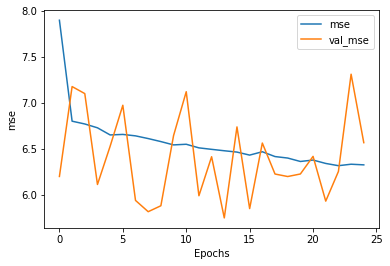

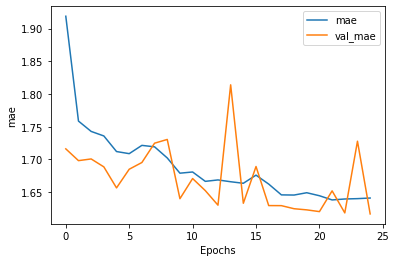

In [100]:
plot_graphs(history, "mse") 
plot_graphs(history, "mae") 

In [ ]:
#Pruebas

# tres modelos con distintos parametros y comparacion
# modelo con regularizacion L2
# modelo con dropout

In [217]:
#MODELO 1 (normal)

original_model = models.Sequential()
original_model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))

original_model.add(layers.Flatten()) 
original_model.add(layers.Dense(256, activation='relu'))  #Dense = 64,128
original_model.add(layers.Dense(256, activation='relu'))    
original_model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(lr=0.0001) #otro 0

original_model.compile(loss='mean_absolute_error', # 'mae'
            #optimizer='RMSprop', # RMSprop or adam
            optimizer=optimizer,
            metrics=['mse','mae'])  #mae

original_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 300)           6641400   
_________________________________________________________________
flatten_3 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1920256   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 8,627,705
Trainable params: 1,986,305
Non-trainable params: 6,641,400
_________________________________________________________________


In [218]:
original_hist = original_model.fit(x_train_pad,y_train,
                   epochs=30, #epochs=30
                   batch_size=52,    #512             
                   validation_data=(x_test_pad, y_test))  

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7fba158a6be0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Assign object at 0x7fba158a6be0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
463/466 [============================>.] - ETA: 0s - loss: 1.8383 - mse: 7.6482 - mae: 1.8383WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fba1584fa60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `e

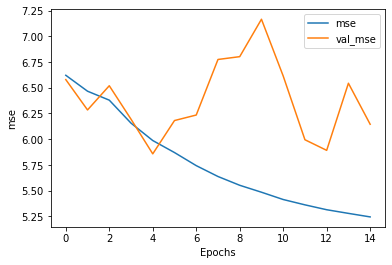

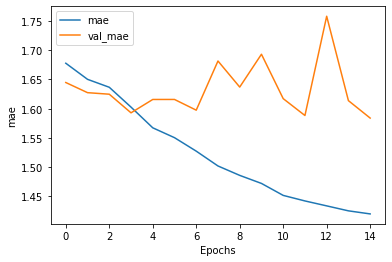

In [182]:
plot_graphs(original_hist, "mse") 
plot_graphs(original_hist, "mae") 

In [183]:
#MODELO 2 (small)

smaller_model = models.Sequential()
smaller_model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))

smaller_model.add(layers.Flatten()) 
smaller_model.add(layers.Dense(128, activation='relu'))  #Dense = 64,128
smaller_model.add(layers.Dense(128, activation='relu'))    
smaller_model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(lr=0.0001) #otro 0

smaller_model.compile(loss='mean_absolute_error', 
            #optimizer='RMSprop', # RMSprop or adam
            optimizer=optimizer,
            metrics=['mse','mae'])  #mae

smaller_model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 25, 300)           6641400   
_________________________________________________________________
flatten_3 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               960128    
_________________________________________________________________
dense_75 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 129       
Total params: 7,618,169
Trainable params: 976,769
Non-trainable params: 6,641,400
_________________________________________________________________


/Applications/anaconda3/envs/autocomplete/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [184]:
smaller_model_hist = smaller_model.fit(x_train_pad,y_train,
                   epochs=15, #epochs=30
                   batch_size=64,    #512             
                   validation_data=(x_val_pad, y_val))  

Epoch 1/15
303/303 [==============================] - 4s 12ms/step - loss: 2.0438 - mse: 9.3708 - mae: 2.0438 - val_loss: 1.6680 - val_mse: 6.8592 - val_mae: 1.6680
Epoch 2/15
303/303 [==============================] - 4s 13ms/step - loss: 1.6948 - mse: 6.7260 - mae: 1.6948 - val_loss: 1.6537 - val_mse: 6.2416 - val_mae: 1.6537
Epoch 3/15
303/303 [==============================] - 4s 12ms/step - loss: 1.6724 - mse: 6.6211 - mae: 1.6724 - val_loss: 1.6341 - val_mse: 6.4564 - val_mae: 1.6341
Epoch 4/15
303/303 [==============================] - 4s 14ms/step - loss: 1.6543 - mse: 6.4991 - mae: 1.6543 - val_loss: 1.6417 - val_mse: 6.7970 - val_mae: 1.6417
Epoch 5/15
303/303 [==============================] - 3s 10ms/step - loss: 1.6407 - mse: 6.3994 - mae: 1.6407 - val_loss: 1.6056 - val_mse: 6.2233 - val_mae: 1.6056
Epoch 6/15
303/303 [==============================] - 3s 10ms/step - loss: 1.6140 - mse: 6.2605 - mae: 1.6140 - val_loss: 1.6248 - val_mse: 6.5057 - val_mae: 1.6248
Epoch 7/15

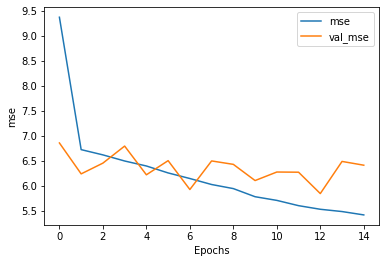

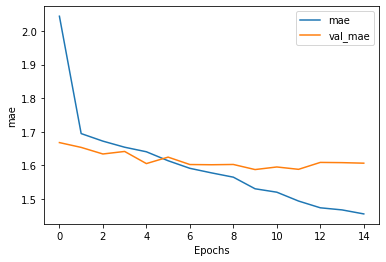

In [185]:
plot_graphs(smaller_model_hist, "mse") 
plot_graphs(smaller_model_hist, "mae") 

In [188]:
epochs = range(1, 16)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

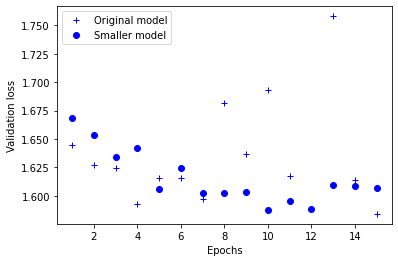

In [189]:
import matplotlib.pyplot as plt

plt.plot(epochs, original_val_loss, 'b+', label='Original model')

plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [200]:
#MODELO 3 (big)

bigger_model  = models.Sequential()
bigger_model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))

bigger_model.add(layers.Flatten())
bigger_model.add(layers.Dense(512, activation='relu'))  
bigger_model.add(layers.Dense(512, activation='relu'))    
bigger_model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(lr=0.001) 

bigger_model.compile(loss='mean_absolute_error', 
            optimizer=optimizer,
            metrics=['mse','mae'])  

bigger_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 25, 300)           6641400   
_________________________________________________________________
flatten_7 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               3840512   
_________________________________________________________________
dense_87 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 513       
Total params: 10,745,081
Trainable params: 4,103,681
Non-trainable params: 6,641,400
_________________________________________________________________


/Applications/anaconda3/envs/autocomplete/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [201]:
bigger_model_hist = bigger_model.fit(x_train_pad,y_train,
                   epochs=15, 
                   batch_size=64,                
                   validation_data=(x_val_pad, y_val)) 

Epoch 1/15
303/303 [==============================] - 11s 34ms/step - loss: 1.8676 - mse: 7.9593 - mae: 1.8676 - val_loss: 1.6872 - val_mse: 7.0066 - val_mae: 1.6872
Epoch 2/15
303/303 [==============================] - 10s 33ms/step - loss: 1.6939 - mse: 6.6976 - mae: 1.6939 - val_loss: 1.6387 - val_mse: 6.6754 - val_mae: 1.6387
Epoch 3/15
303/303 [==============================] - 9s 31ms/step - loss: 1.6519 - mse: 6.4792 - mae: 1.6519 - val_loss: 1.6309 - val_mse: 6.3851 - val_mae: 1.6309
Epoch 4/15
303/303 [==============================] - 10s 32ms/step - loss: 1.6337 - mse: 6.2889 - mae: 1.6337 - val_loss: 1.6255 - val_mse: 6.1406 - val_mae: 1.6255
Epoch 5/15
303/303 [==============================] - 10s 33ms/step - loss: 1.5975 - mse: 6.1571 - mae: 1.5975 - val_loss: 1.5982 - val_mse: 6.3314 - val_mae: 1.5982
Epoch 6/15
303/303 [==============================] - 9s 30ms/step - loss: 1.5662 - mse: 5.9807 - mae: 1.5662 - val_loss: 1.6206 - val_mse: 5.9368 - val_mae: 1.6206
Epoch 

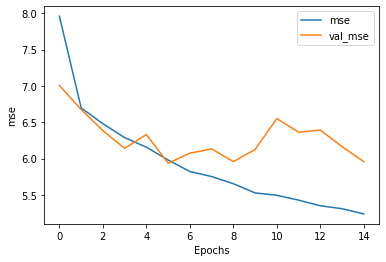

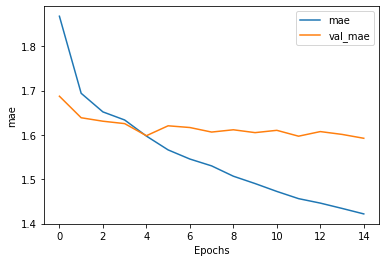

In [202]:
plot_graphs(bigger_model_hist, "mse") 
plot_graphs(bigger_model_hist, "mae") 

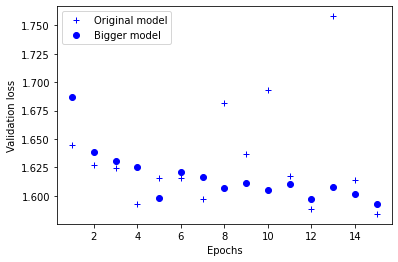

In [203]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### Regularizacion L2

In [204]:
from keras import regularizers

In [93]:
#Modelo con Regularizacion L2

l2_model = models.Sequential()
l2_model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))

l2_model.add(layers.Flatten()) 
l2_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
l2_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
l2_model.add(layers.Dense(1))


optimizer = keras.optimizers.Adam(lr=0.001) 

l2_model.compile(optimizer=optimizer,
                 loss='mean_absolute_error',
                 metrics=['mse','mae'])


model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 25, 300)      5605200     input_4[0][0]                    
__________________________________________________________________________________________________
tf.unstack_1 (TFOpLambda)       [(None, 300), (None, 0           embedding_6[0][0]                
__________________________________________________________________________________________________
average_1 (Average)             (None, 300)          0           tf.unstack_1[0][0]               
                                                                 tf.unstack_1[0][1]         

In [95]:
l2_model_hist = l2_model.fit(x_train_pad,y_train,
                             epochs=35,
                             batch_size=64,
                             validation_data=(x_val_pad, y_val))

Epoch 1/35
298/298 [==============================] - 9s 29ms/step - loss: 2.7148 - mse: 9.8720 - mae: 2.1528 - val_loss: 2.0451 - val_mse: 6.9947 - val_mae: 1.7463
Epoch 2/35
298/298 [==============================] - 10s 32ms/step - loss: 2.0181 - mse: 6.9378 - mae: 1.7537 - val_loss: 1.9237 - val_mse: 6.7721 - val_mae: 1.7347
Epoch 3/35
298/298 [==============================] - 9s 28ms/step - loss: 1.8790 - mse: 6.6291 - mae: 1.7038 - val_loss: 1.8464 - val_mse: 6.7822 - val_mae: 1.7070
Epoch 4/35
298/298 [==============================] - 8s 25ms/step - loss: 1.8274 - mse: 6.7343 - mae: 1.6965 - val_loss: 1.8290 - val_mse: 6.4900 - val_mae: 1.7191
Epoch 5/35
298/298 [==============================] - 7s 24ms/step - loss: 1.7943 - mse: 6.5328 - mae: 1.6882 - val_loss: 1.8926 - val_mse: 6.2830 - val_mae: 1.7980
Epoch 6/35
298/298 [==============================] - 7s 24ms/step - loss: 1.7646 - mse: 6.3709 - mae: 1.6730 - val_loss: 1.8625 - val_mse: 7.6106 - val_mae: 1.7726
Epoch 7/3

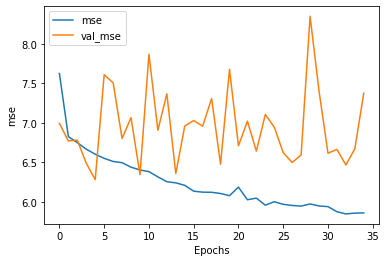

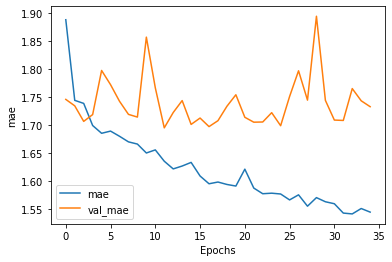

In [96]:
plot_graphs(l2_model_hist, "mse") 
plot_graphs(l2_model_hist, "mae") 

In [97]:
evaluate_train = l2_model.evaluate(x_train_pad, y_train)

596/596 [==============================] - 4s 7ms/step - loss: 1.5897 - mse: 6.1760 - mae: 1.5225


In [98]:
evaluate_validation = l2_model.evaluate(x_val_pad, y_val)

256/256 [==============================] - 2s 6ms/step - loss: 1.8004 - mse: 7.3778 - mae: 1.7332


In [99]:
evaluate_test = l2_model.evaluate(x_test_pad, y_test)

95/95 [==============================] - 1s 11ms/step - loss: 1.7104 - mse: 6.6888 - mae: 1.6432


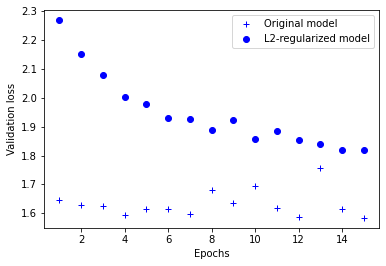

In [211]:
#modelo original (primero) vs. modelo con regularizacion L2

l2_model_val_loss = l2_model_hist.history['val_loss']


plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

### DROPOUT

In [100]:
#MODELO 1 (normal)

dpt_model = models.Sequential()
dpt_model.add(Embedding(input_dim=len_word_index + 1
                   ,output_dim = embedding_dim
                   , weights=[embedding_matrix]
                   ,input_length=max_length
                   ,trainable=False))

dpt_model.add(layers.Flatten())
dpt_model.add(layers.Dense(256, activation='relu'))  #Dense = 64,128
dpt_model.add(layers.Dropout(0.2))
dpt_model.add(layers.Dense(256, activation='relu'))  
dpt_model.add(layers.Dropout(0.2))
dpt_model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(lr=0.001) #otro 0

dpt_model.compile(loss='mean_absolute_error', # 'mae'
            #optimizer='RMSprop', # RMSprop or adam
            optimizer=optimizer,
            metrics=['mse','mae'])  #mae

dpt_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 25, 300)           5605200   
_________________________________________________________________
flatten_4 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               1920256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [102]:
dpt_model_hist = dpt_model.fit(x_train_pad,y_train,
                   epochs=35, 
                   batch_size=64,              
                   validation_data=(x_val_pad, y_val)) 

Epoch 1/35
298/298 [==============================] - 6s 19ms/step - loss: 1.8883 - mse: 7.1816 - mae: 1.8883 - val_loss: 2.1020 - val_mse: 6.7001 - val_mae: 2.1020
Epoch 2/35
298/298 [==============================] - 6s 19ms/step - loss: 1.8321 - mse: 6.9355 - mae: 1.8321 - val_loss: 2.3065 - val_mse: 7.2595 - val_mae: 2.3065
Epoch 3/35
298/298 [==============================] - 6s 19ms/step - loss: 1.8190 - mse: 6.8604 - mae: 1.8190 - val_loss: 2.4306 - val_mse: 7.8339 - val_mae: 2.4306
Epoch 4/35
298/298 [==============================] - 6s 20ms/step - loss: 1.7742 - mse: 6.7121 - mae: 1.7742 - val_loss: 2.0053 - val_mse: 6.4126 - val_mae: 2.0053
Epoch 5/35
298/298 [==============================] - 6s 21ms/step - loss: 1.7434 - mse: 6.5339 - mae: 1.7434 - val_loss: 2.2817 - val_mse: 7.2416 - val_mae: 2.2817
Epoch 6/35
298/298 [==============================] - 7s 23ms/step - loss: 1.7215 - mse: 6.4270 - mae: 1.7215 - val_loss: 2.3630 - val_mse: 7.5464 - val_mae: 2.3630
Epoch 7/35

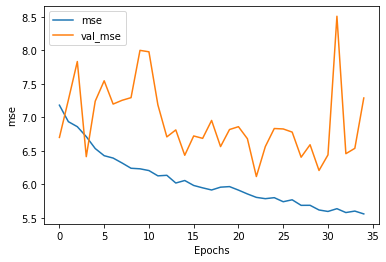

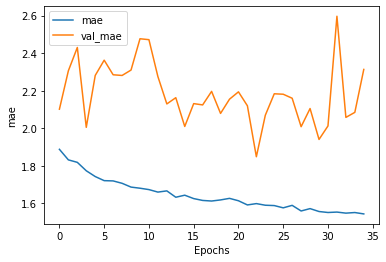

In [103]:
#grafico 
plot_graphs(dpt_model_hist, "mse") 
plot_graphs(dpt_model_hist, "mae") 

In [104]:
evaluate_train = dpt_model.evaluate(x_train_pad, y_train)

596/596 [==============================] - 3s 5ms/step - loss: 2.0999 - mse: 6.1134 - mae: 2.0999


In [105]:
evaluate_validation = dpt_model.evaluate(x_val_pad, y_val)

256/256 [==============================] - 1s 5ms/step - loss: 2.3137 - mse: 7.2893 - mae: 2.3137


In [106]:
evaluate_test = dpt_model.evaluate(x_test_pad, y_test)

95/95 [==============================] - 1s 6ms/step - loss: 2.3055 - mse: 7.1620 - mae: 2.3055


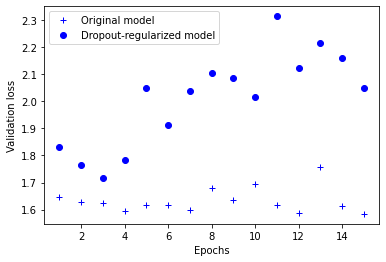

In [217]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

3333plt.show()